<a href="https://colab.research.google.com/github/DerekZ66/ALY6110/blob/main/ALY6110_Regression%26RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import pylab as pl
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col,isnan, when, count
import pyspark.sql.functions as F
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
from google.colab import files
files.upload()

In [ ]:
df = spark.read.csv('housing.csv',inferSchema=True, header =True)

In [ ]:
# show null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [ ]:
# multiple median_income by 10000 to standarize the monetory amount
df = df.withColumn("median_income", df["median_income"] * 10000)

In [ ]:
# fill null values with mean
total_bedrooms_mean = df.select(F.mean('total_bedrooms')).collect()[0][0]
df.fillna(value = total_bedrooms_mean)
df=df.na.fill(value=total_bedrooms_mean, subset=["total_bedrooms"])

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [ ]:
# factorize ocean_proximity
ocean_proximity_factor = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_type")
df = ocean_proximity_factor.fit(df).transform(df)
df.show()
df.select("ocean_proximity", "ocean_proximity_type").distinct().show()

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|ocean_proximity|ocean_proximity_type|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+
|  -122.23|   37.88|                41|        880|           129|       322|       126|           83252.0|            452600|       NEAR BAY|                 3.0|
|  -122.22|   37.86|                21|       7099|          1106|      2401|      1138| 83013.99999999999|            358500|       NEAR BAY|                 3.0|
|  -122.24|   37.85|                52|       1467|           190|       496|       177|           72574.0|            352100|       NEAR BAY|                 3.0|
|  -122.25|   37

In [ ]:
df = df.drop("ocean_proximity")
df = df.withColumnRenamed("ocean_proximity_type", "ocean_proximity")
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+
|  -122.23|   37.88|                41|        880|           129|       322|       126|           83252.0|            452600|            3.0|
|  -122.22|   37.86|                21|       7099|          1106|      2401|      1138| 83013.99999999999|            358500|            3.0|
|  -122.24|   37.85|                52|       1467|           190|       496|       177|           72574.0|            352100|            3.0|
|  -122.25|   37.85|                52|       1274|           235|       558|       219| 56430.99999999999|            341300|            3.0|

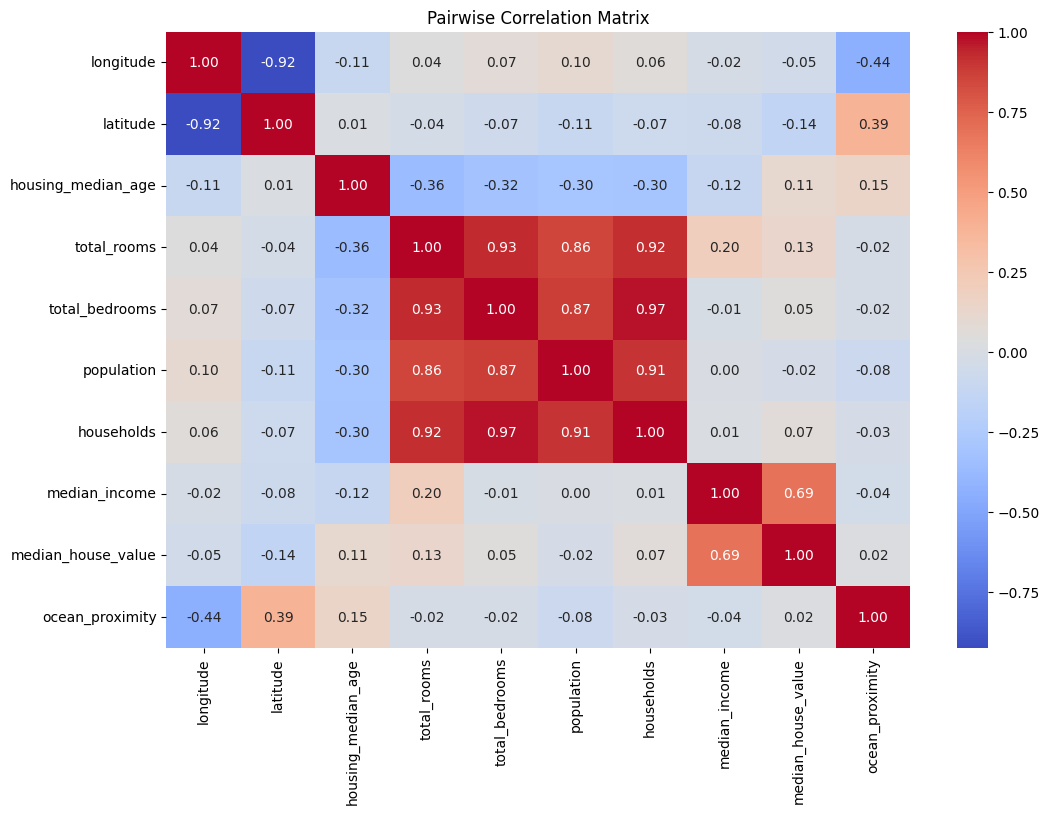

In [ ]:
# Calculate the pairwise correlation matrix
correlation_matrix = df.toPandas().corr()

# Plot the correlation heatmap with correlation valuss as annotations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10})
plt.title('Pairwise Correlation Matrix')
plt.show()

In [ ]:
only_features = ['households','population','total_bedrooms','median_income','total_rooms','housing_median_age','ocean_proximity']

# vectorize the features
assembler = VectorAssembler(inputCols=only_features, outputCol="features")
assembled_df = assembler.transform(df)

# feature scaling
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

# inspect the result
scaled_df.select("features", "features_scaled").show(5, truncate=False)

+--------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+
|features                                                |features_scaled                                                                                                                        |
+--------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+
|[126.0,322.0,129.0,83252.0,880.0,41.0,3.0]              |[0.3295584480852433,0.2843362208866199,0.30768012429380304,4.382095394195218,0.40337085073160667,3.2577023016083064,2.9864139366491074]|
|[1138.0,2401.0,1106.0,83013.99999999999,7099.0,21.0,3.0]|[2.9764882057222772,2.1201592122632746,2.6379396703019085,4.369567902917909,3.2540109878905406,1.668579227653035,2.9864139366491074]   |
|[177.0,496.0,190.0,72574

In [ ]:
import pprint
# split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=1000)

# Create a Linear Regression Estimator
lr = LinearRegression(featuresCol="features_scaled", labelCol="median_house_value")
lr_model = lr.fit(train_data)

coefficients = lr_model.coefficients

intercept = lr_model.intercept

# Print the coefficients with the name of the features
print("Model - Multivariable Linear Regression")
print("Coefficients:")
pprint.pprint(dict(zip(only_features, lr_model.coefficients)))
print("Intercept: %f" %intercept)


# Summarize the model over the training set and print out some metrics
trainingSummary = lr_model.summary
print("Performance of the model on the training data:")
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f \n" % trainingSummary.r2)


# Make predictions on the test data
predictions = lr_model.evaluate(test_data)


rmse_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
print("Performance of the model on the testing data:")
print("RMSE: %f" % rmse_evaluator.evaluate(predictions.predictions))
print("r2: %f \n" % r2_evaluator.evaluate(predictions.predictions))

Model - Multivariable Linear Regression
Coefficients:
{'households': 54786.826233238105,
 'housing_median_age': 23814.95406992098,
 'median_income': 89656.73375532494,
 'ocean_proximity': 969.742803860717,
 'population': -39896.31014951316,
 'total_bedrooms': 33077.57724957307,
 'total_rooms': -40377.54900695925}
Intercept: -45780.743314
Performance of the model on the training data:
RMSE: 76407.100955
r2: 0.557089 

Performance of the model on the testing data:
RMSE: 74641.700898
r2: 0.597944 



In [ ]:
# perform lasso regression
lasso_regression = LinearRegression(featuresCol='features_scaled', labelCol="median_house_value",  elasticNetParam=1, maxIter=10)
linearModel = lasso_regression.fit(train_data)

# Print the coefficients with the name of the features
print("Model - LASSO Regression")
print("Coefficients:")
pprint.pprint(dict(zip(only_features, linearModel.coefficients)))
print("Intercept: %s \n" % str(linearModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = linearModel.summary
print("Performance of the model on the training data:")
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f \n" % trainingSummary.r2)


# Make predictions on the test data
ls_predictions = linearModel.transform(test_data)

# Summarize the model over the testing set and print out some metrics
rmse_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
print("Performance of the model on the testing data:")
print("RMSE: %f" % rmse_evaluator.evaluate(ls_predictions))
print("r2: %f \n" % r2_evaluator.evaluate(ls_predictions))

Model - LASSO Regression
Coefficients:
{'households': 54786.826233238105,
 'housing_median_age': 23814.95406992098,
 'median_income': 89656.73375532494,
 'ocean_proximity': 969.742803860717,
 'population': -39896.31014951316,
 'total_bedrooms': 33077.57724957307,
 'total_rooms': -40377.54900695925}
Intercept: -45780.74331391428 

Performance of the model on the training data:
RMSE: 76407.100955
r2: 0.557089 

Performance of the model on the testing data:
RMSE: 74641.700898
r2: 0.597944 



In [ ]:
from pyspark.ml.regression import RandomForestRegressor
# Create a RandomForestRegressor model
rf = RandomForestRegressor(labelCol="median_house_value", numTrees=100, maxDepth=10)

# Split the data into training and testing sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2],seed=1000)

# Fit the Random Forest model to the training data
rf_model = rf.fit(train_data)

# Make predictions on the test dataset
rf_predictions = rf_model.transform(test_data)

# Evaluate the Random Forest model using appropriate metrics (e.g., RMSE or MAE)
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rf_predictions)

evaluator_mae = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(rf_predictions)


print("Random Forest RMSE:", rmse)
print("Random Forest MAE:", mae)


Random Forest RMSE: 62278.3784767632
Random Forest MAE: 45053.583572827614


In [ ]:
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
r_squared = evaluator.evaluate(rf_predictions)

print("Random Forest R-squared (R2):", r_squared)

Random Forest R-squared (R2): 0.7201031227398356


In [ ]:
feature_importances = rf_model.featureImportances

In [ ]:
# input_features = assembled_df.getInputCols()
only_features

['households',
 'population',
 'total_bedrooms',
 'median_income',
 'total_rooms',
 'housing_median_age',
 'ocean_proximity']

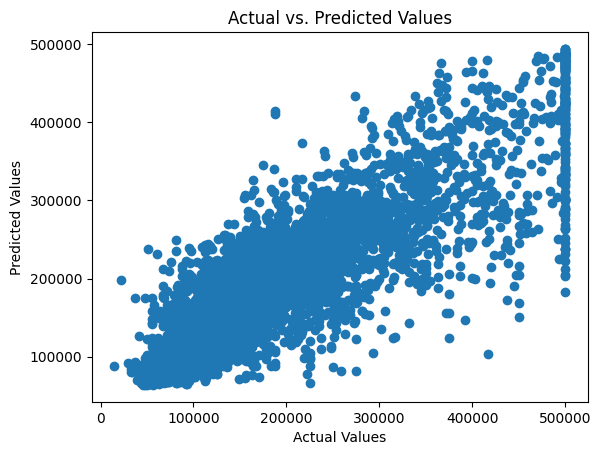

In [ ]:
# Assuming you have a Pandas DataFrame with actual and predicted values
actual = test_data.select("median_house_value").toPandas()
predicted = rf_predictions.select("prediction").toPandas()

plt.scatter(actual, predicted)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

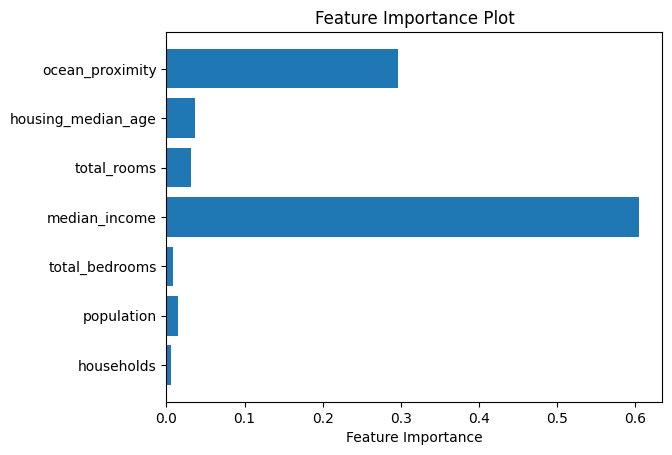

In [ ]:
importances = feature_importances.toArray()
indices = range(len(importances))

plt.barh(indices, importances, align="center")
plt.yticks(indices, only_features)
plt.xlabel("Feature Importance")
plt.title("Feature Importance Plot")
plt.show()

In [ ]:
importances

array([0.00634775, 0.01510517, 0.00833879, 0.60501324, 0.03186506,
       0.03656134, 0.29676864])

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

df = df.select("median_income", "ocean_proximity", "median_house_value")
feature_assembler = VectorAssembler(inputCols=["median_income", "ocean_proximity"], outputCol="features")
df = feature_assembler.transform(df)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1000)
lr = LinearRegression(featuresCol="features", labelCol="median_house_value")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")



evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {r2}")

coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")


Root Mean Squared Error (RMSE): 83798.2976466277
Root Mean Squared Error (RMSE): 0.4835019156351502
Coefficients: [4.188956184342191,5265.96157041907]
Intercept: 39783.126701908215


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf = RandomForestRegressor(labelCol="median_house_value")

# Create a parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [100, 200, 300]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Create a cross-validator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2"),
                          numFolds=5)  # You can adjust the number of folds

# Fit the cross-validator to the training data
cv_model = crossval.fit(train_data)

# Make predictions on the test dataset
rf_predictions = cv_model.transform(test_data)

# Evaluate the tuned Random Forest model
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
r2_evaluator = evaluator.evaluate(rf_predictions)

print("Tuned Random Forest R2:", r2)

# Print the best hyperparameters
best_model = cv_model.bestModel
print("Best hyperparameters:")
print(f"Number of Trees: {best_model.getNumTrees}")
print(f"Max Depth: {best_model.getOrDefault('maxDepth')}")

Tuned Random Forest R2: 0.4835019156351502
Best hyperparameters:
Number of Trees: 100
Max Depth: 10
